look at changes in returns before and after ESG changes.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import invgamma
import datetime
import scipy
import importlib
import os, sys
sys.path.insert(0, 'C:/Users/User/Code/MMDGraph')
import seaborn as sns
import pandas as pd
import MMDforGraphs as mg
import statsmodels.api as sm

ModuleNotFoundError: No module named 'MMDforGraphs'

Read ESG data

In [ ]:
PRICE = pd.read_csv("../Yahoo/YAHOO_PRICE.csv")
ESG_data = pd.read_excel("../Yahoo/YAHOO_PRICE_ESG.xlsx", sheet_name= 'ESG')
TICKERS = np.unique(ESG_data['ticker'])
companies = np.unique(PRICE['ticker']) 


esg_series = ESG_data.copy()  #ESG_data.loc[ESG_data['ticker'] == 'BMY'].copy()
esg_series['timestamp'] = pd.to_datetime(esg_series['timestamp'])
min_date = datetime.datetime(2014,10, 1)
max_date = np.max(ESG_data['timestamp'])
esg_series['date'] = esg_series['timestamp'].dt.date
print(min_date)
print(max_date)
esg_series


# Create a series of days, which will then be joined with esg_series, To create "daily" ESG.
dates = pd.DataFrame({'date':pd.date_range(min_date,max_date,freq='d')})
dates['date'] = dates['date'].dt.date

# create an esg data frame where index is monthly
esg_pivot = esg_series[['ticker', 'esgScore', 'date']].copy()
esg_pivot_diff = pd.pivot_table(esg_pivot, values = 'esgScore', index = 'date', columns= 'ticker').diff()#.iloc[1:]
esg_pivot = pd.pivot_table(esg_pivot, values = 'esgScore', index = 'date', columns= 'ticker')
esg_pivot = pd.merge(dates, esg_pivot, how = 'left', left_on='date', right_index=True)
esg_pivot_diff = pd.merge(dates, esg_pivot_diff, how = 'left', left_on='date', right_index=True)
esg_pivot.set_index('date', inplace= True)
esg_pivot_diff.set_index('date', inplace= True)
#esg_pivot = esg_pivot.loc[esg_pivot.index <= datetime.date(2019, 11, 1)]

asset_profiles = pd.read_excel("../Yahoo/YAHOO_PRICE_ESG.xlsx", sheet_name= 'asset_profiles') 

esg_pivot_enough_data = esg_pivot.loc[:,~np.isnan(esg_pivot.iloc[0,:])]
sector_classification = dict()
for company in esg_pivot_enough_data.columns:
    sector_of_company = asset_profiles['sector'].loc[asset_profiles['ticker'] == company].iloc[0]
    if sector_of_company not in sector_classification.keys():
        sector_classification[sector_of_company] = list()
    sector_classification[sector_of_company].append(company)

esg_pivot



2014-10-01 00:00:00
2022-02-01 00:00:00


,A,AAL,AAP,AAPL,ABBV,ABC,ABT,ACN,ADBE,ADI,...,PYPL,RE,SCHW,STZ,T,TAP,TECH,WRB,XOM,XRAY
date,,,,,,,,,,,,,,,,,,,,,
2014-10-01,71.00,73.00,48.00,60.00,62.00,55.00,64.00,72.00,70.00,64.00,...,NaN,45.00,50.00,54.0,65.00,73.0,NaN,45.00,65.00,57.00
2014-10-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-10-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-10-04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-10-05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-01-28,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-01-29,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-01-30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Read Price

In [ ]:
asset_profiles = pd.read_excel("../Yahoo/YAHOO_PRICE_ESG.xlsx", sheet_name= 'asset_profiles') 
price_data = pd.read_csv("../Yahoo/YAHOO_PRICE.csv")

price_data['timestamp'] = pd.to_datetime(price_data['timestamp'])
price_filtered = price_data.loc[price_data['timestamp'] > datetime.datetime(2014,9, 1), price_data.columns]
price_filtered['date'] = price_filtered['timestamp'].dt.date

price_filtered['return'] = price_filtered.sort_values('date').groupby(['ticker']).adjclose.pct_change()


price_pivot = price_filtered[['ticker', 'return', 'date']].copy()
price_pivot['return'] = np.log(1 + price_pivot['return'])
price_pivot = price_pivot.dropna()  # Drop rows which contain missing values
price_pivot = pd.pivot_table(price_pivot, values = 'return', index = 'date', columns= 'ticker')
price_pivot.shape

# Let's order the columns by sector
company_df = pd.DataFrame({'ticker': np.array(price_pivot.columns)})
company_df = pd.merge(company_df, asset_profiles, on='ticker', how = 'left')
company_df['track_index'] = np.array(range(company_df.shape[0]))
company_df = company_df.sort_values(by = 'sector')
price_pivot = price_pivot.iloc[:, company_df['track_index']]

Get market index

In [ ]:
def get_index(tick):
    """
    Function that takes the sp500 index from yahoo
    """
    import requests
    headers = {'User-Agent': 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_11_5) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/50.0.2661.102 Safari/537.36'}
    # ESG historical data (only changes yearly)
    url_esg = f"https://query1.finance.yahoo.com/v7/finance/spark?symbols={tick}&range=10y&interval=1d&indicators=close&includeTimestamps=false&includePrePost=false&corsDomain=finance.yahoo.com&.tsrc=finance"
    response = requests.get(url_esg, headers=headers)
    if response.ok:
        sp500 = pd.DataFrame({'date':pd.to_datetime(response.json()['spark']['result'][0]['response'][0]['timestamp'], unit= 's'),
                              'price':response.json()['spark']['result'][0]['response'][0]['indicators']['quote'][0]['close']})
    
    else:
        print("Empty data frame")
        sp500 = pd.DataFrame()



    return sp500

In [ ]:
sp500 = get_index('^GSPC')
sp500['date'] = pd.to_datetime(sp500['date']).dt.date
sp500['return'] = 1 + sp500['price'].pct_change()
sp500['log_return'] = np.log(sp500['price']).diff()
sp500 = sp500.iloc[:,:].dropna(axis= 0)
sp500 = sp500.set_index('date')

# Perform on Single asset

In [84]:
stock  = 'AAPL'
y_esg = esg_pivot_diff[stock]
y = price_pivot[stock]
x = sp500['log_return']

data = pd.merge(y_esg, y, left_index = True, right_index = True, how = 'left')
data = pd.merge(data, sp500.loc[:, 'log_return'], left_index = True, right_index = True, how = 'left')
data.head(20)


,AAPL_x,AAPL_y,log_return
date,,,
2014-10-01,-1.0,-0.015706,-0.013337
2014-10-02,NaN,0.007233,0.000005
2014-10-03,NaN,-0.002807,0.011104
2014-10-04,NaN,NaN,NaN
2014-10-05,NaN,NaN,NaN
2014-10-06,NaN,0.000000,-0.001566
2014-10-07,NaN,-0.008772,-0.015242
2014-10-08,NaN,0.020547,0.017311
2014-10-09,NaN,0.002180,-0.020878


Green is where esg decreases and red is where increase

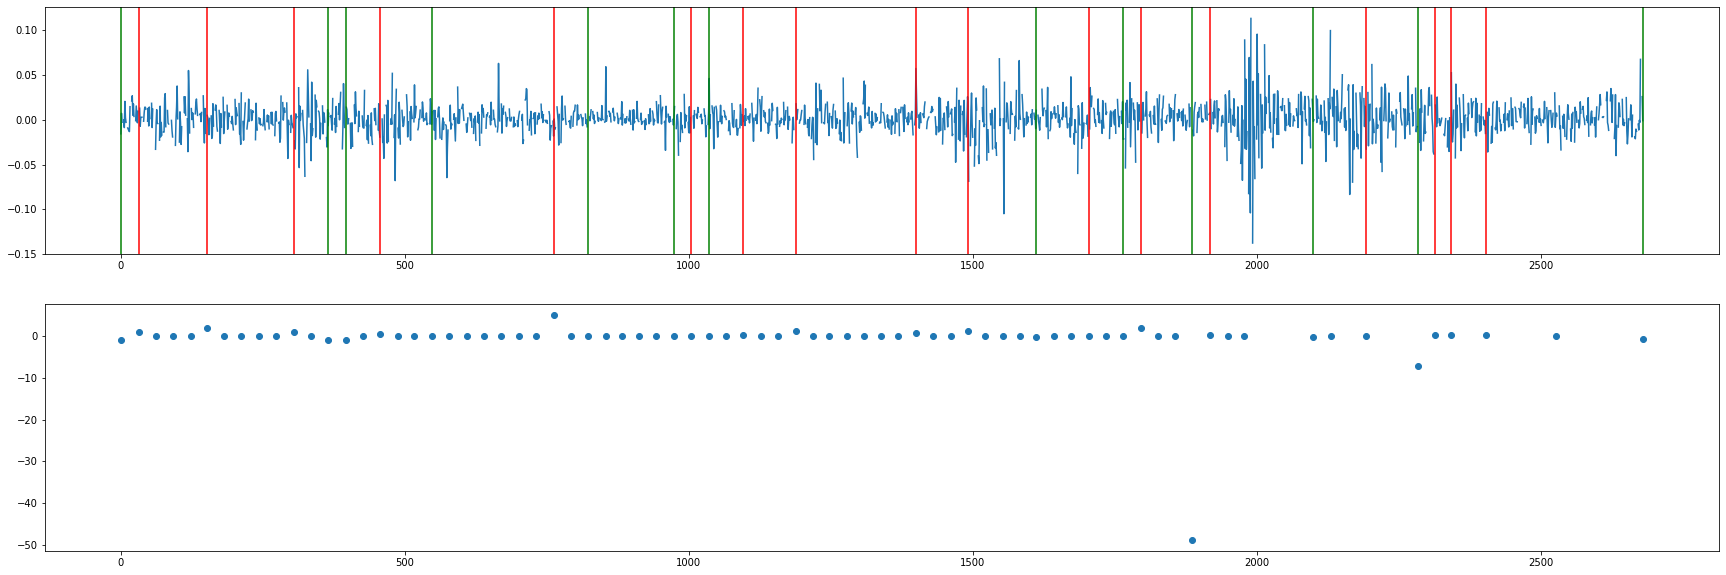

In [85]:
fix, ax = plt.subplots(2,1, figsize = (30,10))
ax[0].plot(range(data.shape[0]), data['AAPL_y'])
for i, esg in enumerate(data['AAPL_x']):
    if esg != 0 and ~np.isnan(esg):
        if(esg <0):
            ax[0].axvline(i, color = 'green')
        else:
            ax[0].axvline(i, color = 'red')

ax[1].scatter(range(data.shape[0]), data['AAPL_x'])


In [86]:
from arch import arch_model

y = price_pivot[stock].loc[(price_pivot.index >= np.min(esg_pivot.index)) & (price_pivot.index <= np.max(esg_pivot.index))]
x = sp500['log_return'].loc[(sp500.index >= np.min(esg_pivot.index)) & (sp500.index <= np.max(esg_pivot.index))]

am = arch_model(100*y, 100*x, mean='LS', p=1, q=1, dist="StudentsT")
from scipy import stats
from statsmodels.stats.stattools import durbin_watson
from statsmodels.stats.diagnostic import acorr_ljungbox
res = am.fit()
print(acorr_ljungbox(res.resid / res.conditional_volatility, lags = [1]))

Iteration:      1,   Func. Count:      8,   Neg. LLF: 50916.38856245669
Iteration:      2,   Func. Count:     18,   Neg. LLF: 29987.391548610198
Iteration:      3,   Func. Count:     27,   Neg. LLF: 9106.592760888198
Iteration:      4,   Func. Count:     36,   Neg. LLF: 6194.442401413386
Iteration:      5,   Func. Count:     45,   Neg. LLF: 4200.228009616778
Iteration:      6,   Func. Count:     53,   Neg. LLF: 4267.616342868734
Iteration:      7,   Func. Count:     61,   Neg. LLF: 2798.0346784048425
Iteration:      8,   Func. Count:     69,   Neg. LLF: 2797.126336471718
Iteration:      9,   Func. Count:     77,   Neg. LLF: 2793.6864479536953
Iteration:     10,   Func. Count:     85,   Neg. LLF: 2790.704206192777
Iteration:     11,   Func. Count:     92,   Neg. LLF: 2790.6808736771627
Iteration:     12,   Func. Count:     99,   Neg. LLF: 2790.6676209369
Iteration:     13,   Func. Count:    106,   Neg. LLF: 2790.639042258546
Iteration:     14,   Func. Count:    113,   Neg. LLF: 2790.638

C:\Users\User\AppData\Local\Temp\ipykernel_15172\1917998877.py:3: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  df = pd.concat([std_resid, unit_var_resid], 1)


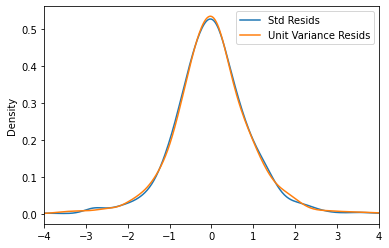

In [87]:
std_resid = res.resid / res.conditional_volatility
unit_var_resid = res.resid / res.resid.std()
df = pd.concat([std_resid, unit_var_resid], 1)
df.columns = ["Std Resids", "Unit Variance Resids"]
subplot = df.plot(kind="kde", xlim=(-4, 4))

In [88]:
y_clean = pd.DataFrame({'y_clean':res.resid/res.conditional_volatility}, index = y.index)
y_clean[y_clean > 2] = 2
y_clean[y_clean < -2] = -2

In [89]:
data = pd.merge(data, y_clean, left_index = True, right_index = True, how = 'left')
data.head(20)

,AAPL_x,AAPL_y,log_return,y_clean
date,,,,
2014-10-01,-1.0,-0.015706,-0.013337,-0.034017
2014-10-02,NaN,0.007233,0.000005,0.687917
2014-10-03,NaN,-0.002807,0.011104,-1.635375
2014-10-04,NaN,NaN,NaN,NaN
2014-10-05,NaN,NaN,NaN,NaN
2014-10-06,NaN,0.000000,-0.001566,0.136872
2014-10-07,NaN,-0.008772,-0.015242,0.840724
2014-10-08,NaN,0.020547,0.017311,-0.022193
2014-10-09,NaN,0.002180,-0.020878,2.000000


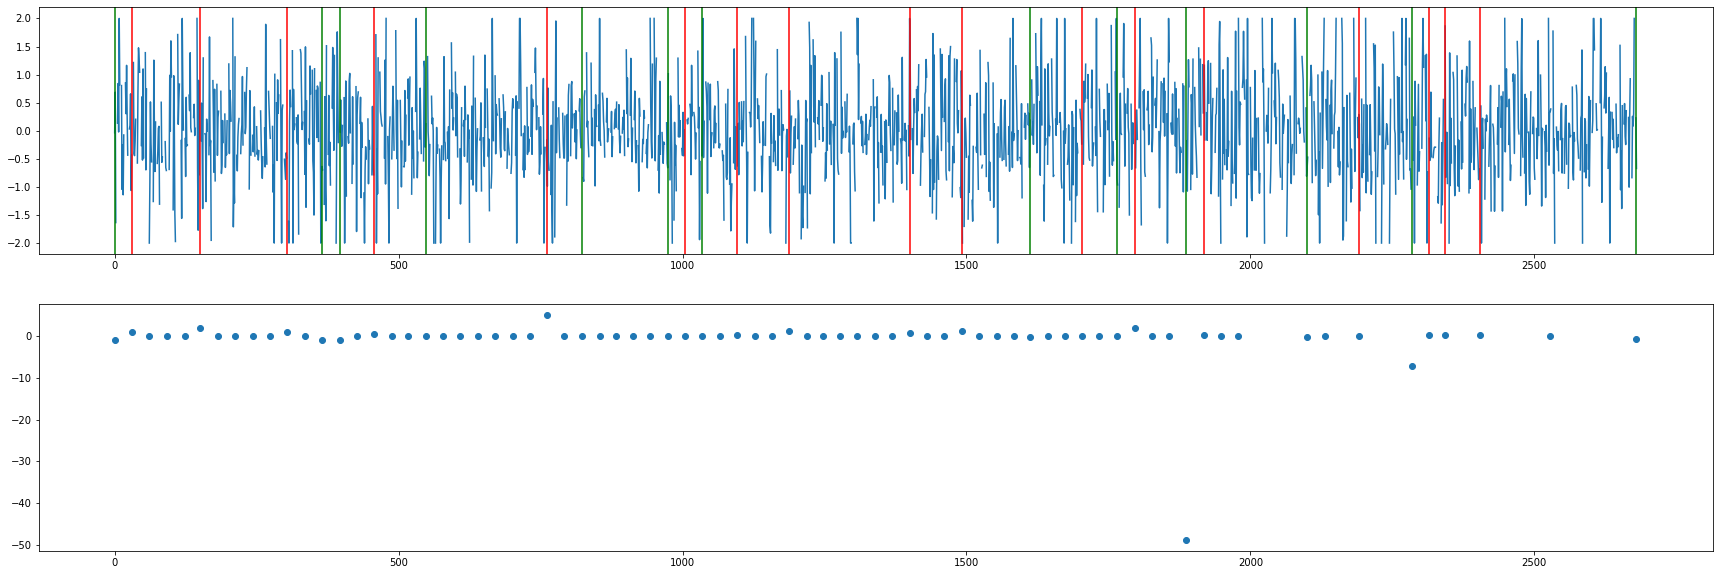

In [90]:
fix, ax = plt.subplots(2,1, figsize = (30,10))
ax[0].plot(range(data.shape[0]), data['y_clean'])
for i, esg in enumerate(data['AAPL_x']):
    if esg != 0 and ~np.isnan(esg):
        if(esg <0):
            ax[0].axvline(i, color = 'green')
        else:
            ax[0].axvline(i, color = 'red')

ax[1].scatter(range(data.shape[0]), data['AAPL_x'])


Let's check 30 days before and after each line. We also take the truncate returns to -0.002 and 0.002.



In [95]:
importlib.reload(sys.modules['MMDforGraphs'])

esg_changes = []
for i, esg in enumerate(data['AAPL_x']):
    if esg != 0 and ~np.isnan(esg):
        if(esg <0):
            ax[0].axvline(i, color = 'green')
        else:
            ax[0].axvline(i, color = 'red')
        esg_changes.append(data.index[i])
        #base = data.index[i]

        #print(date_list = [base - datetime.timedelta(days=x) for x in range(30)])


# Take 30 days before and after
for i in range(1, len(esg_changes)-1):
    base = esg_changes[i]
    last_base = esg_changes[i-1]
    next_base = esg_changes[i+1]
    date_list_before = [base - datetime.timedelta(days=x) for x in range(1,31)]
    y_before = y[np.isin(y.index, date_list_before) & (y.index >=last_base)]
    date_list_after = [base + datetime.timedelta(days=x) for x in range(30)]
    y_after = y[np.isin(y.index, date_list_after) & (y.index < next_base)]

    # number of samples
    n_1 = len(y_before)
    n_2 = len(y_after)

    from sklearn.metrics.pairwise import euclidean_distances

    Z = np.expand_dims(np.r_[y_before, y_after], axis=1)
    D2 = euclidean_distances(Z, squared=True)
    upper = D2[np.triu_indices_from(D2, k=1)]
    kernel_width = np.median(upper, overwrite_input=True)
    bandwidth = np.sqrt(kernel_width / 2)
    kernel_width = 2 * bandwidth**2

    K = np.exp(-D2 * (1/kernel_width))

    print("------ new -------")
    # Wild bootstrap
    mmd_b_p, test, statistic_sample = mg.WildBootstrap(K, 10,n_1 , n_2, 1000)  
    # print(statistic_sample)
    print(f' Wild bootstrap: {mmd_b_p}, iteration {i}')


    MMD_functions = [mg.MMD_b, mg.MMD_u]
    function_arguments=[dict(n = n_1, m = n_2 ), dict(n = n_1, m = n_2 )]
    kernel_hypothesis = mg.BoostrapMethods(MMD_functions)
    kernel_hypothesis.Bootstrap(K, function_arguments, B = 1000, method = 'NBB', boot_arg = {'n':n_1, 'm':n_2, 'l':3} )
    print(f'p_value Block {kernel_hypothesis.p_values}')
    kernel_hypothesis.Bootstrap(K, function_arguments, B = 1000 )
    print(f'p_value  {kernel_hypothesis.p_values}')

    

    

------ new -------
 Wild bootstrap: 0.141, iteration 1
p_value Block {'MMD_b': 0.561, 'MMD_u': 0.454}
p_value  {'MMD_b': 0.497, 'MMD_u': 0.413}
------ new -------
 Wild bootstrap: 0.092, iteration 2
p_value Block {'MMD_b': 0.488, 'MMD_u': 0.486}
p_value  {'MMD_b': 0.53, 'MMD_u': 0.505}
------ new -------
 Wild bootstrap: 0.084, iteration 3
p_value Block {'MMD_b': 0.441, 'MMD_u': 0.489}
p_value  {'MMD_b': 0.368, 'MMD_u': 0.429}
------ new -------
 Wild bootstrap: 0.092, iteration 4
p_value Block {'MMD_b': 0.443, 'MMD_u': 0.473}
p_value  {'MMD_b': 0.441, 'MMD_u': 0.475}
------ new -------
 Wild bootstrap: 0.473, iteration 5
p_value Block {'MMD_b': 0.929, 'MMD_u': 0.915}
p_value  {'MMD_b': 0.927, 'MMD_u': 0.907}
------ new -------
 Wild bootstrap: 0.01, iteration 6
p_value Block {'MMD_b': 0.125, 'MMD_u': 0.172}
p_value  {'MMD_b': 0.22, 'MMD_u': 0.28}
------ new -------
 Wild bootstrap: 0.033, iteration 7
p_value Block {'MMD_b': 0.295, 'MMD_u': 0.296}
p_value  {'MMD_b': 0.171, 'MMD_u': 0.1

In [93]:
n_2

19

# Test all companies

In [6]:
def mmd_test(y_before, y_after, ln = 1, block_length = 3):
    """
    Wild bootstrap
    Block bootstrap
    Permutation bootstrap
    
    """
    # number of samples
    n_1 = len(y_before)
    n_2 = len(y_after)

    from sklearn.metrics.pairwise import euclidean_distances

    Z = np.expand_dims(np.r_[y_before, y_after], axis=1)
    D2 = euclidean_distances(Z, squared=True)
    upper = D2[np.triu_indices_from(D2, k=1)]
    kernel_width = np.median(upper, overwrite_input=True)
    bandwidth = np.sqrt(kernel_width / 2)
    kernel_width = 2 * bandwidth**2

    K = np.exp(-D2 * (1/kernel_width))

    #print("------ new -------")
    # Wild bootstrap
    wild_p_val, test, statistic_sample = mg.WildBootstrap(K, ln, n_1 , n_2, 1000)  
    # print(statistic_sample)
    #print(f' Wild bootstrap: {mmd_b_p}, iteration {i}')


    MMD_functions = [mg.MMD_b, mg.MMD_u]
    function_arguments=[dict(n = n_1, m = n_2 ), dict(n = n_1, m = n_2 )]
    kernel_hypothesis = mg.BoostrapMethods(MMD_functions)
    kernel_hypothesis.Bootstrap(K, function_arguments, B = 1000, method = 'NBB', boot_arg = {'n':n_1, 'm':n_2, 'l':block_length} )
    #print(f'p_value Block {kernel_hypothesis.p_values}')
    block_p_val = kernel_hypothesis.p_values['MMD_u']
    kernel_hypothesis.Bootstrap(K, function_arguments, B = 1000 )
    #print(f'p_value  {kernel_hypothesis.p_values}')
    p_val = kernel_hypothesis.p_values['MMD_u']

    return wild_p_val, block_p_val, p_val

In [7]:
df = pd.read_pickle(f'../data/ESG_uni/run_31032022.pkl')
df

,stock,sector,date,direction_up,n_before,n_after,mmd_wild_raw,mmd_block_raw,mmd_perm_raw,mmd_wild_median,mmd_block_median,mmd_perm_median,mmd_wild_garch,mmd_block_garch,mmd_perm_garch
0,A,Healthcare,2014-11-01,1,22,19,0.348,0.510,0.396,0.398,0.522,0.533,0.574,0.701,0.685
1,A,Healthcare,2015-03-01,0,20,21,0.444,0.569,0.555,0.834,0.905,0.894,0.884,0.929,0.936
2,A,Healthcare,2015-11-01,0,21,20,0.558,0.700,0.567,0.415,0.531,0.430,0.620,0.738,0.704
3,A,Healthcare,2015-12-01,1,20,21,0.562,0.715,0.546,0.061,0.105,0.057,0.052,0.075,0.076
4,A,Healthcare,2016-01-01,0,21,19,0.201,0.160,0.321,0.006,0.011,0.028,0.017,0.024,0.027
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1934,DRI,Consumer Cyclical,2019-12-01,0,20,20,0.342,0.353,0.373,0.516,0.626,0.660,0.483,0.605,0.619
1935,DRI,Consumer Cyclical,2020-01-01,0,21,20,0.278,0.219,0.314,0.114,0.117,0.160,0.173,0.220,0.235
1936,DRI,Consumer Cyclical,2020-07-01,0,22,21,0.338,0.513,0.421,0.537,0.574,0.618,0.730,0.813,0.824
1937,DRI,Consumer Cyclical,2020-10-01,1,21,22,0.878,0.924,0.941,0.242,0.261,0.328,0.424,0.392,0.494


In [11]:
np.isin(stock, df['stock'])

array(True)

In [8]:
from statsmodels.stats.diagnostic import acorr_ljungbox
from arch import arch_model
import pickle
import tqdm
# df = pd.DataFrame()
pbar = tqdm.tqdm(total= np.sum([len(v) for k, v in sector_classification.items() ]))

for k, v in sector_classification.items():

    for stock in v:

        if np.isin(stock, df['stock']):
            pbar.update()
            continue

        y_esg = esg_pivot_diff[stock]
        y = price_pivot[stock]
        x = sp500['log_return']

        y = pd.merge(y,x, left_index=True, right_index=True)
        y = y.dropna()

        data = pd.merge(y_esg, y, left_index = True, right_index = True, how = 'left')

        tmp = pd.DataFrame({'stock':stock, 'sector':k}, index = [0])


        # Fit median
        covariates = pd.DataFrame({'market': y.loc[:,'log_return']})
        covariates['const'] = 1
        model_robust = sm.QuantReg(y[stock], covariates)
        results_robust = model_robust.fit(q = 0.5, max_iter = 10000)
        y_hat_rob = model_robust.predict(results_robust.params)
        #tmp['autocorrelation_median'] = acorr_ljungbox(y_hat_rob, lags = [1]).iloc[0,1]
        y_hat_rob = pd.DataFrame({'y_median':y_hat_rob - y.loc[:,stock]}, index = y.index)

        # Garch volatilities
        am = arch_model(100*y[stock], 100*y['log_return'], mean='LS', p=1, q=1, dist="StudentsT")
        res = am.fit(disp = 'off')
        #tmp['autocorrelation_garch'] = acorr_ljungbox(res.resid / res.conditional_volatility, lags = [1]).iloc[0,1]
        y_garch = pd.DataFrame({'y_garch':res.resid / res.conditional_volatility}, index = y.index)

        # Check esg changes
        esg_changes = []
        esg_changes_numeric = []
        for i, esg in enumerate(data[stock + "_x"]):
            if esg != 0 and ~np.isnan(esg):
                esg_changes.append(data.index[i])
                esg_changes_numeric.append(esg)

            # For all ESG changes, check before and after

        for i in range(1, len(esg_changes)-1):

            tmp = pd.DataFrame({'stock':stock, 'sector':k}, index = [0])

            base = esg_changes[i]
            tmp['date'] = base
            last_base = esg_changes[i-1]
            next_base = esg_changes[i+1]
            date_list_before = [base - datetime.timedelta(days=x) for x in range(1,31)]
            date_list_after = [base + datetime.timedelta(days=x) for x in range(30)]
            tmp['direction_up'] = (esg_changes_numeric[i] > 0)*1

            y_before = np.array(y[stock].loc[np.isin(y.index, date_list_before) & (y.index >=last_base)])
            y_after = np.array(y[stock].loc[np.isin(y.index, date_list_after) & (y.index < next_base)])

            tmp['n_before'] = len(y_before)
            tmp['n_after'] = len(y_after)

            if len(y_before) == 0 or len(y_after) == 0:
                continue


            wild_p_val, block_p_val, p_val = mmd_test(y_before, y_after, ln = 1)
            tmp['mmd_wild_raw'] = wild_p_val
            tmp['mmd_block_raw'] = block_p_val
            tmp['mmd_perm_raw'] = p_val

            y_before = np.array(y_hat_rob['y_median'].loc[np.isin(y.index, date_list_before) & (y.index >=last_base)])
            y_after = np.array(y_hat_rob['y_median'].loc[np.isin(y.index, date_list_after) & (y.index < next_base)])

            wild_p_val, block_p_val, p_val = mmd_test(y_before, y_after, ln = 1)
            tmp['mmd_wild_median'] = wild_p_val
            tmp['mmd_block_median'] = block_p_val
            tmp['mmd_perm_median'] = p_val

            y_before = np.array(y_garch['y_garch'].loc[np.isin(y.index, date_list_before) & (y.index >=last_base)])
            y_after = np.array(y_garch['y_garch'].loc[np.isin(y.index, date_list_after) & (y.index < next_base)])

            wild_p_val, block_p_val, p_val = mmd_test(y_before, y_after, ln = 1)
            tmp['mmd_wild_garch'] = wild_p_val
            tmp['mmd_block_garch'] = block_p_val
            tmp['mmd_perm_garch'] = p_val

            df = pd.concat((df, tmp), ignore_index=True)


        with open('../data/ESG_uni/run_31032022.pkl', 'wb') as f:
            pickle.dump(df, f)

        pbar.update()

pbar.close()


        



100%|██████████| 307/307 [52:43<00:00, 10.30s/it]


In [19]:
pbar.close()

In [9]:
df

,stock,sector,date,direction_up,n_before,n_after,mmd_wild_raw,mmd_block_raw,mmd_perm_raw,mmd_wild_median,mmd_block_median,mmd_perm_median,mmd_wild_garch,mmd_block_garch,mmd_perm_garch
0,A,Healthcare,2014-11-01,1,22,19,0.348,0.510,0.396,0.398,0.522,0.533,0.574,0.701,0.685
1,A,Healthcare,2015-03-01,0,20,21,0.444,0.569,0.555,0.834,0.905,0.894,0.884,0.929,0.936
2,A,Healthcare,2015-11-01,0,21,20,0.558,0.700,0.567,0.415,0.531,0.430,0.620,0.738,0.704
3,A,Healthcare,2015-12-01,1,20,21,0.562,0.715,0.546,0.061,0.105,0.057,0.052,0.075,0.076
4,A,Healthcare,2016-01-01,0,21,19,0.201,0.160,0.321,0.006,0.011,0.028,0.017,0.024,0.027
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6341,T,Communication Services,2020-01-01,0,21,20,0.158,0.163,0.199,0.057,0.124,0.078,0.019,0.058,0.022
6342,T,Communication Services,2020-02-01,0,21,19,0.545,0.479,0.568,0.906,0.958,0.941,0.712,0.733,0.768
6343,T,Communication Services,2020-07-01,0,22,21,0.113,0.186,0.180,0.800,0.885,0.873,0.556,0.662,0.648
6344,T,Communication Services,2020-10-01,1,21,22,0.369,0.473,0.361,0.233,0.368,0.301,0.221,0.294,0.290


In [10]:
rejection_alpha = 0.05
for col in ['mmd_wild_raw',	'mmd_block_raw',	'mmd_perm_raw',
                'mmd_wild_median',	'mmd_block_median',	'mmd_perm_median',	
                'mmd_wild_garch',	'mmd_block_garch',	'mmd_perm_garch']:

    df[col + '_r'] = (df[col] < rejection_alpha)*1

Fraction of rejections for each sector:

In [11]:
df[['sector', 'mmd_wild_raw_r',	'mmd_block_raw_r',	'mmd_perm_raw_r',
                'mmd_wild_median_r',	'mmd_block_median_r',	'mmd_perm_median_r',	
                'mmd_wild_garch_r',	'mmd_block_garch_r',	'mmd_perm_garch_r']].groupby(['sector'], as_index=False).agg(['mean'])#sum()

,mmd_wild_raw_r,mmd_block_raw_r,mmd_perm_raw_r,mmd_wild_median_r,mmd_block_median_r,mmd_perm_median_r,mmd_wild_garch_r,mmd_block_garch_r,mmd_perm_garch_r
,mean,mean,mean,mean,mean,mean,mean,mean,mean
sector,,,,,,,,,
Basic Materials,0.086567,0.056716,0.074627,0.113433,0.068657,0.086567,0.074627,0.041791,0.050746
Communication Services,0.065292,0.051546,0.048110,0.085911,0.061856,0.065292,0.082474,0.065292,0.048110
Consumer Cyclical,0.110000,0.081429,0.078571,0.100000,0.077143,0.084286,0.087143,0.060000,0.064286
Consumer Defensive,0.100164,0.055829,0.067323,0.091954,0.059113,0.064039,0.073892,0.050903,0.047619
Energy,0.077170,0.048232,0.054662,0.096463,0.070740,0.051447,0.057878,0.045016,0.041801
Financial Services,0.112009,0.093533,0.087760,0.115473,0.079677,0.090069,0.095843,0.063510,0.071594
Healthcare,0.127059,0.090588,0.095294,0.107059,0.071765,0.077647,0.084706,0.054118,0.058824
Industrials,0.125850,0.087302,0.100907,0.115646,0.088435,0.091837,0.100907,0.062358,0.070295


Fraction of rejection per sector and per ESG change direction:

In [13]:
df[['sector','direction_up', 'mmd_wild_raw_r',	'mmd_block_raw_r',	'mmd_perm_raw_r',
                'mmd_wild_median_r',	'mmd_block_median_r',	'mmd_perm_median_r',	
                'mmd_wild_garch_r',	'mmd_block_garch_r',	'mmd_perm_garch_r']].groupby(['sector', 'direction_up'], as_index=False).agg(['mean'])#sum()

mmd_wild_raw_r mmd_block_raw_r  \
                                              mean            mean   
sector                 direction_up                                  
Basic Materials        0                  0.089385        0.055866   
                       1                  0.083333        0.057692   
Communication Services 0                  0.055172        0.034483   
                       1                  0.075342        0.068493   
Consumer Cyclical      0                  0.111392        0.083544   
                       1                  0.108197        0.078689   
Consumer Defensive     0                  0.101604        0.048128   
                       1                  0.097872        0.068085   
Energy                 0                  0.105590        0.074534   
                       1                  0.046667        0.020000   
Financial Services     0                  0.116090        0.087576   
                       1                  0.106667        0.101333   
Healthcare             0                  0.121569        0.080392   
                       1                  0.135294        0.105882   
Industrials            0                  0.108614        0.080524   
                       1                  0.152299        0.097701   
Real Estate            0                  0.102941        0.073529   
                       1                  0.057692        0.048077   
Technology             0                  0.083744        0.059113   
                       1                  0.150538        0.107527   
Utilities              0                  0.112840        0.070039   
                       1                  0.079295        0.061674   

                                    mmd_perm_raw_r mmd_wild_median_r  \
                                              mean              mean   
sector                 direction_up                                    
Basic Materials        0                  0.083799          0.134078   
                       1                  0.064103          0.089744   
Communication Services 0                  0.048276          0.096552   
                       1                  0.047945          0.075342   
Consumer Cyclical      0                  0.091139          0.118987   
                       1                  0.062295          0.075410   
Consumer Defensive     0                  0.061497          0.096257   
                       1                  0.076596          0.085106   
Energy                 0                  0.074534          0.111801   
                       1                  0.033333          0.080000   
Financial Services     0                  0.089613          0.099796   
                       1                  0.085333          0.136000   
Healthcare             0                  0.090196          0.103922   
                       1                  0.102941          0.111765   
Industrials            0                  0.084270          0.119850   
                       1                  0.126437          0.109195   
Real Estate            0                  0.073529          0.051471   
                       1                  0.028846          0.057692   
Technology             0                  0.071429          0.105911   
                       1                  0.123656          0.112903   
Utilities              0                  0.081712          0.101167   
                       1                  0.057269          0.088106   

                                    mmd_block_median_r mmd_perm_median_r  \
                                                  mean              mean   
sector                 direction_up                                        
Basic Materials        0                      0.089385          0.083799   
                       1                      0.044872          0.089744   
Communication Services 0                      0.082759          0.055172   
                       1    